In [1]:
from pathlib import Path
import subprocess
import time
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from whirligig import beamforming, data

def download_icloud(path):
    
    filename = path.name.split('.icloud')[0]
    filename = filename[1:]
    command = f'/usr/bin/brctl download {path}'
    subprocess.run(command.split())
    while not (path.parents[0]/filename).exists():
        time.sleep(0.25)

    return path.parents[0]/filename

def evict_icloud(path):
    
    filename = path.name
    filename = '.'+filename+'.icloud'
    command = f'/usr/bin/brctl evict {path}'
    output = subprocess.run(command.split(), capture_output=True)
    print(output)
    #while (path.exists(), check=True):
    #    time.sleep(0.25)
    
    return path.parents[0]/filename

def unzip_data(path):
    
    with open(ZipFile(path, r)) as myfile:
        print(myfile.namelist())
        
penn_state_vna_frequencies = np.linspace(25.81e9, 26.01e9, 801)

In [2]:
penn_state_vna_frequencies[0::8]

array([2.5810e+10, 2.5812e+10, 2.5814e+10, 2.5816e+10, 2.5818e+10,
       2.5820e+10, 2.5822e+10, 2.5824e+10, 2.5826e+10, 2.5828e+10,
       2.5830e+10, 2.5832e+10, 2.5834e+10, 2.5836e+10, 2.5838e+10,
       2.5840e+10, 2.5842e+10, 2.5844e+10, 2.5846e+10, 2.5848e+10,
       2.5850e+10, 2.5852e+10, 2.5854e+10, 2.5856e+10, 2.5858e+10,
       2.5860e+10, 2.5862e+10, 2.5864e+10, 2.5866e+10, 2.5868e+10,
       2.5870e+10, 2.5872e+10, 2.5874e+10, 2.5876e+10, 2.5878e+10,
       2.5880e+10, 2.5882e+10, 2.5884e+10, 2.5886e+10, 2.5888e+10,
       2.5890e+10, 2.5892e+10, 2.5894e+10, 2.5896e+10, 2.5898e+10,
       2.5900e+10, 2.5902e+10, 2.5904e+10, 2.5906e+10, 2.5908e+10,
       2.5910e+10, 2.5912e+10, 2.5914e+10, 2.5916e+10, 2.5918e+10,
       2.5920e+10, 2.5922e+10, 2.5924e+10, 2.5926e+10, 2.5928e+10,
       2.5930e+10, 2.5932e+10, 2.5934e+10, 2.5936e+10, 2.5938e+10,
       2.5940e+10, 2.5942e+10, 2.5944e+10, 2.5946e+10, 2.5948e+10,
       2.5950e+10, 2.5952e+10, 2.5954e+10, 2.5956e+10, 2.5958e

In [4]:
evict_icloud(file)

NameError: name 'file' is not defined

In [4]:
file_repository = Path.home()/'iCloud'/'penn_state_synca_data'/'vna'
file_name = list(file_repository.glob('.211119*.h5.icloud'))[0]

file = download_icloud(file_repository/file_name)

In [4]:
penn_h5file = h5py.File(file, 'r')
penn_data = penn_h5file['0']
penn_data = penn_data[:, 0:120, 0::16]
print(penn_data.shape)
penn_h5file.close()

(31, 120, 51)


# check beamforming phases

In [5]:
x = np.linspace(0, 0.03, 31)
y = np.zeros(x.size)
coordinates = np.array([x,y],).T
print(coordinates.shape)
n_channel = 120
phases = beamforming.TestPhaseModel(n_channel, coordinates, roll=-29)
print(phases.shape)

(31, 2)
(120, 31, 1)


In [6]:
penn_phase_data = np.angle(penn_data)
penn_phase_data = np.unwrap(penn_phase_data, axis=1)
penn_phase_data -= penn_phase_data[:, 0, :][:, np.newaxis, :]

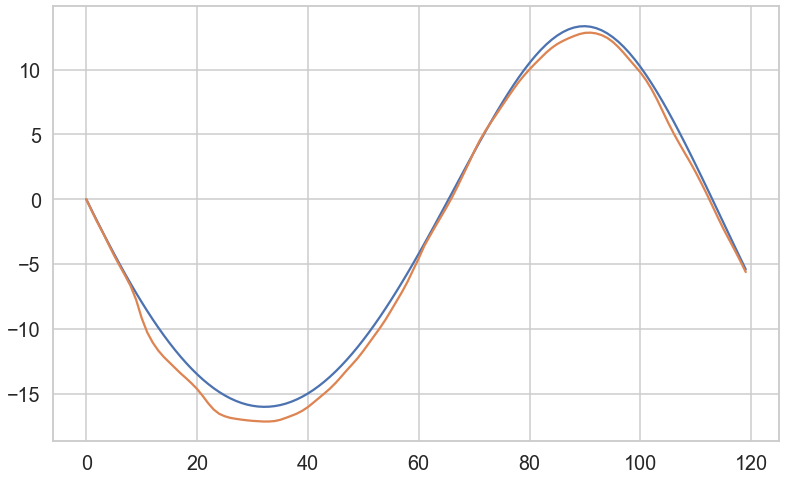

In [7]:
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

ax.plot(phases[:, 30, 0])
ax.plot(penn_phase_data[30, :, :].mean(axis=-1))

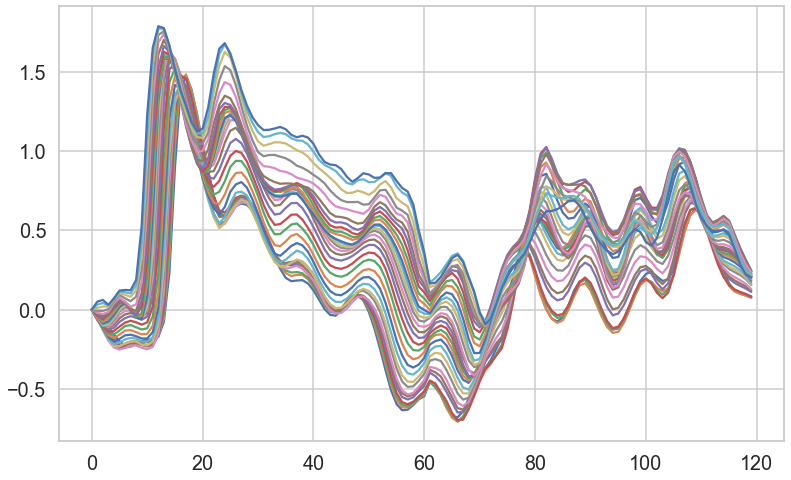

In [8]:
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1)

for i in range(penn_phase_data.shape[0]):
    
    ax.plot(phases[:, i, 0] -penn_phase_data[i, :, :].mean(axis=-1) )

# beamforming with PSU data

In [5]:
x_coord = np.linspace(-0.04, 0.04, 81)
y_coord = np.linspace(-0.04, 0.04, 81)
results_save_path = Path.home()/'iCloud'/'penn_state_synca_data'/'beamforming'/'221216_beamforming_characterization'
results_save_path.mkdir(exist_ok=True, parents=True)



In [6]:
for z in ['0', '5', '10', '-5', '-10']:
    penn_h5file = h5py.File(file, 'r')
    penn_data = penn_h5file[z]
    penn_data = penn_data[:, 0:120, 0::4]
    penn_h5file.close()

    for i in range(penn_data.shape[0]):
        temp_vna_data = data.VNAData(penn_data[i, :, :], penn_state_vna_frequencies[0::4])
        beamforming.BeamformingProcessor(
            temp_vna_data,
            x_coord,
            y_coord,
            model='PSU',
            phase_cal = np.zeros(120),
            mag_cal = np.ones(120)
        )
        beamforming.BeamformingImageProcessor(temp_vna_data, model='PSU')
        beamforming.BeamformingMaximumProcessor(temp_vna_data)
        
        result_name = f'z{z}r{i}.h5'
        
        temp_vna_data.save(results_save_path/result_name)
        output = subprocess.run(['ls', results_save_path], capture_output=True)
        #print(output)
        #evicted_file = evict_icloud(results_save_path/result_name)
        
        print(f'Progress = {round(100*(i+1)/penn_data.shape[0], 1)}%, z = {z}')
        
        

Progress = 3.2%, z = 0
Progress = 6.5%, z = 0
Progress = 9.7%, z = 0
Progress = 12.9%, z = 0
Progress = 16.1%, z = 0
Progress = 19.4%, z = 0
Progress = 22.6%, z = 0
Progress = 25.8%, z = 0
Progress = 29.0%, z = 0
Progress = 32.3%, z = 0
Progress = 35.5%, z = 0
Progress = 38.7%, z = 0
Progress = 41.9%, z = 0
Progress = 45.2%, z = 0
Progress = 48.4%, z = 0
Progress = 51.6%, z = 0
Progress = 54.8%, z = 0
Progress = 58.1%, z = 0
Progress = 61.3%, z = 0
Progress = 64.5%, z = 0
Progress = 67.7%, z = 0
Progress = 71.0%, z = 0
Progress = 74.2%, z = 0
Progress = 77.4%, z = 0
Progress = 80.6%, z = 0
Progress = 83.9%, z = 0
Progress = 87.1%, z = 0
Progress = 90.3%, z = 0
Progress = 93.5%, z = 0
Progress = 96.8%, z = 0
Progress = 100.0%, z = 0
Progress = 3.2%, z = 5
Progress = 6.5%, z = 5
Progress = 9.7%, z = 5
Progress = 12.9%, z = 5
Progress = 16.1%, z = 5
Progress = 19.4%, z = 5
Progress = 22.6%, z = 5
Progress = 25.8%, z = 5
Progress = 29.0%, z = 5
Progress = 32.3%, z = 5
Progress = 35.5%, z =